## The audio features analysis

In this notebook we investigate the features of the most successful songs from the Billboard Hot 100 List.

The features have been collected using the [Spotify Web API](https://developer.spotify.com/documentation/web-api) and stored in the <a href='spotify_API_logs\spotify_audio_features_log.csv'>`spotify_audio_features_log.csv`</a> file. The data are based on the <a href='music_data_scraper\billboard_500_yearly.json'>`billboard_500_yearly.json`</a> dictionary, in which one can find the Top 500 tracks of each year within 1958-2023 period. All the details on the records collection and processing are described in the <a href='0-data_collection.ipynb'>`0-data_collection.ipynb`</a> notebook.

In [1]:
import re
from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set mpl parameters for clarity
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['legend.edgecolor'] = 'k'

Let's begin with loading the data and observing all the information available for each track. We remove the mismatched songs (not found by the API), leaving only the ones with all the features accessible.

In [2]:
# load the original data frame
spot_af = pd.read_csv('spotify_API_logs/spotify_audio_features_log.csv', 
    parse_dates=['date'], sep=';')

# grab the matched songs only
spot_af.dropna(how='any', inplace=True)

spot_af.iloc[0]

date                                              1958-01-01 00:00:00
artist_orig                                                Big Bopper
song_orig                                              Chantilly Lace
artist_spot                                            The Big Bopper
song_spot                                              Chantilly Lace
artist_spot_id                                 2gNK2HAaLVz5DZoD2moDQj
song_spot_id                                   07GtDOCxmye5KDWsTSACPk
match                                                               1
genres                     ['doo-wop', 'rock-and-roll', 'rockabilly']
danceability                                                    0.489
energy                                                          0.806
key                                                               3.0
loudness                                                       -6.054
mode                                                              1.0
speechiness         

Many of the attributes listed above are technical and irrelevant to our analysis, e.g., the **artist_spot_id** (internal Spotify artist's ID) or the **track_href** (track URL); we will exclude them for clarity.

In general, we truncate the data to four groups of attributes, i.e.:
* **date** (the year of the song occurrence on the List),
* **genres** (the music genres of the song creator),
* **key, mode** and **time_signature** (classical features expressed in integers, which refer to song key, mode and time signature), and
* **danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo** and **duration_ms**  (the main features of the song).

**Note**: The genres correspond to the leading artist of the song - not the track itself (see also the <a href='0-data_collection.ipynb'>`0-data_collection.ipynb`</a> notebook for more information). On the other hand, the last group of features refers to different song characteristics, e.g., its intensity (**energy**) or **loudness**. Some of the features represent the probability of chosen property, like the **acousticness** which measures the confidence (from 0 to 1) of the track being acoustic. The detailed description of all the attributes can be found in the [Web API official documentation](https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features), to which we refer throughout the analysis.

**Note**: The song and the artist labels (Spotify versions only) are also left in the data for possible further references.

After rearranging the frame, we can observe the sample of the records as follows:

In [3]:
# the features (headers)
track = [3, 4]
feat1 = [0, 8, 11, 13, -1]
feat2 = [9, 10, 12] + list(range(14, 20)) + [-2]

# rearrange the data frame
spot_af = spot_af.iloc[:, track + feat1 + feat2].set_index('date')\
    .to_period('Y').astype({'key': int, 'mode': int, 'time_signature': int})\
    .rename(columns={'mode': 'key_mode'})
spot_af.index.name = 'year'
# we rename 'mode' into 'key_mode' to not mislead it with the `mode` pd method

spot_af.sample(3, random_state=0)

,artist_spot,song_spot,genres,key,key_mode,time_signature,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
year,,,,,,,,,,,,,,,,
1962,Jimmy McGriff,I've Got a Woman (Part 1 & 2),"['hammond organ', 'jazz funk', 'jazz organ', '...",5,1,4,0.570,0.463,-14.425,0.0338,0.6350,0.878000,0.229,0.697,119.001,274644.0
1985,Daryl Hall & John Oates,Possession Obsession,"['album rock', 'classic rock', 'heartland rock...",7,0,4,0.749,0.623,-6.427,0.0271,0.1270,0.000003,0.104,0.897,114.814,276773.0
1979,Sammy Hagar,(Sittin' On) The Dock Of The Bay,"['album rock', 'classic rock', 'glam metal', '...",11,0,4,0.655,0.520,-10.262,0.0292,0.0981,0.000000,0.104,0.759,110.824,182467.0


It should be noted that even though we excluded all the 'NaN' records from our data, some of the songs can lack the information on the genres due to their absence in the Spotify database (see the examples given below). This problem corresponds to 2021 tracks in total, which equals around 7.1% of all the records.

In [4]:
spot_af[spot_af.genres == '[]'].sample(3, random_state=0)

,artist_spot,song_spot,genres,key,key_mode,time_signature,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
year,,,,,,,,,,,,,,,,
1978,Pockets,Come Go With Me,[],6,0,4,0.665,0.579,-10.679,0.0475,0.1320,0.000380,0.0563,0.917,119.300,265093.0
1991,Or-N-More,Everyotherday,[],1,0,4,0.780,0.725,-10.044,0.0439,0.0918,0.000018,0.9090,0.831,113.311,232800.0
2004,R. Kelly,Happy People - Album Version with DJ Skit,[],8,1,4,0.828,0.586,-6.274,0.2050,0.0811,0.000000,0.1010,0.802,97.010,469200.0


We begin our investigations from the audio features and their distributions, uncovering how the music properties changed over years.

The simplest class of features involves the **key**, **mode** and **time_signature**, all expressed in integers. The [**time_signature**](https://en.wikipedia.org/wiki/Time_signature) (also known as the meter) is an auditory feature that determines how many beats are contained within one single segment of music track (the so-called *bar*). The most universal meter found in the modern music is 4/4 (four beats per bar), which corresponds to `time_signature = 4` in our data. As shown below, more than 93% of the songs follow this standard. The 3/4 meter (much less popular, but still quite present) can be found in around 5.6% of the tracks.

In [5]:
spot_af.time_signature.value_counts(normalize=True)

time_signature
4    0.932589
3    0.055960
5    0.007869
1    0.003513
0    0.000070
Name: proportion, dtype: float64

The **mode** attribute determines the type of scale in which the song was created (see also the description of the **key** feature below); the possible options are `mode = 1` (the [major scale](https://en.wikipedia.org/wiki/Major_scale)) and `mode = 0` (the [minor scale](https://en.wikipedia.org/wiki/Minor_scale)). The compositions written in major scales are known to be more happy and cheerful than their minor counterparts, which is why the former ones are preferable. In our dateset, the ratio between the modes equals 72% to 28%, in favour of the major one.

In [6]:
spot_af.key_mode.value_counts(normalize=True)

key_mode
1    0.720659
0    0.279341
Name: proportion, dtype: float64

The last feature of the integer type corresponds to the **key** of the scale in which the track was composed. The available keys refer to a simplified integer pitch notation (values from 0 to 11 - see the table available [here](https://en.wikipedia.org/wiki/Pitch_class#Other_ways_to_label_pitch_classes) for more details), and combined with the **mode** attribute, can describe the full scale of the composition. For example, the `key = 0, mode = 1` code determines the *C major* scale, while the `key = 9, mode = 0` scenario, the *A minor* one.

To combine both the keys and the modes, we will transform the **key** column by annotating the major and the minor scales with positive and negative values, respectively. In order to distinguish between the *C major* and the *C minor* cases (the *C* key is expressed by zero), the original values are shifted by one.

In [7]:
# combine the keys and the modes
spot_af = spot_af.assign(key=lambda x: 
    np.where(x.key_mode == 0, -(x.key + 1), x.key + 1))

spot_af.key.value_counts(normalize=True)

key
 1     0.103699
 8     0.093266
 3     0.086205
 10    0.071943
 2     0.070362
 6     0.056135
 9     0.051077
 5     0.048618
 11    0.042927
-12    0.037623
 7     0.036885
 12    0.035093
-6     0.030281
-11    0.028770
-10    0.028243
-5     0.028068
-2     0.025679
-7     0.025398
 4     0.024449
-1     0.020093
-8     0.019637
-3     0.013981
-9     0.013419
-4     0.008150
Name: proportion, dtype: float64

As can be seen, the *C major* scale (`key = 1`) is the most popular one (mainly to its simplicity) and occurs in more than 10% of the tracks. Among other very universal scales we can also indicate the *G major* (`key = 8`), *D major* (`key = 3`), *A major* (`key = 10`) or *C♯/D♭ major* (`key = 2`) ones. The minor modes (annotated using negative values) are much less popular, with the best result corresponding to the *B minor* scale (`key = -12`) in about 3.8% of the songs.

The distribution of the scales might differ between the decades, which can be easily expressed by aggregating our data. In the next cell we present the frequency of the scales occurrences (keys in headers) within each of the available years (the frame index).

In [8]:
# get the frequencies of the scales
scales_freq = pd.get_dummies(spot_af.key).groupby(pd.Grouper(freq='Y'))\
    .sum().apply(lambda x: x / x.sum(), axis=1)

scales_freq

,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,...,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,,,,,,,,,,
1958,0.017606,0.014085,0.014085,0.000000,0.007042,0.000000,0.010563,0.024648,0.007042,0.021127,...,0.059859,0.102113,0.059859,0.088028,0.031690,0.105634,0.045775,0.066901,0.105634,0.028169
1959,0.009828,0.009828,0.014742,0.007371,0.022113,0.007371,0.024570,0.012285,0.009828,0.014742,...,0.066339,0.093366,0.066339,0.063882,0.031941,0.105651,0.066339,0.058968,0.085995,0.024570
1960,0.014320,0.011933,0.009547,0.007160,0.014320,0.004773,0.023866,0.007160,0.009547,0.023866,...,0.073986,0.054893,0.071599,0.109785,0.031026,0.114558,0.078759,0.059666,0.071599,0.028640
1961,0.006711,0.020134,0.017897,0.013423,0.011186,0.011186,0.013423,0.015660,0.004474,0.008949,...,0.100671,0.044743,0.042506,0.098434,0.026846,0.105145,0.053691,0.058166,0.073826,0.026846
1962,0.018391,0.006897,0.006897,0.011494,0.020690,0.013793,0.016092,0.013793,0.004598,0.009195,...,0.075862,0.055172,0.050575,0.105747,0.043678,0.094253,0.064368,0.078161,0.085057,0.029885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,0.034765,0.059305,0.034765,0.024540,0.024540,0.040900,0.044990,0.034765,0.004090,0.010225,...,0.079755,0.012270,0.030675,0.034765,0.034765,0.065440,0.063395,0.042945,0.026585,0.034765
2020,0.034836,0.045082,0.020492,0.026639,0.032787,0.043033,0.053279,0.051230,0.008197,0.010246,...,0.061475,0.006148,0.032787,0.030738,0.051230,0.057377,0.059426,0.047131,0.028689,0.036885
2021,0.045553,0.034707,0.017354,0.010846,0.019523,0.036876,0.032538,0.032538,0.015184,0.008677,...,0.069414,0.019523,0.036876,0.043384,0.045553,0.069414,0.065076,0.058568,0.023861,0.041215


The table presented above can be used to uncover the distribution of the scales within chosen years, as well as observe possible changes in their trends over decades. The examples are shown in the subplots below, where we present the dynamics of the *C major*, *C♯/D♭ major* and *D♯/E♭ major* scales (in the left, the middle and the right panel, respectively).

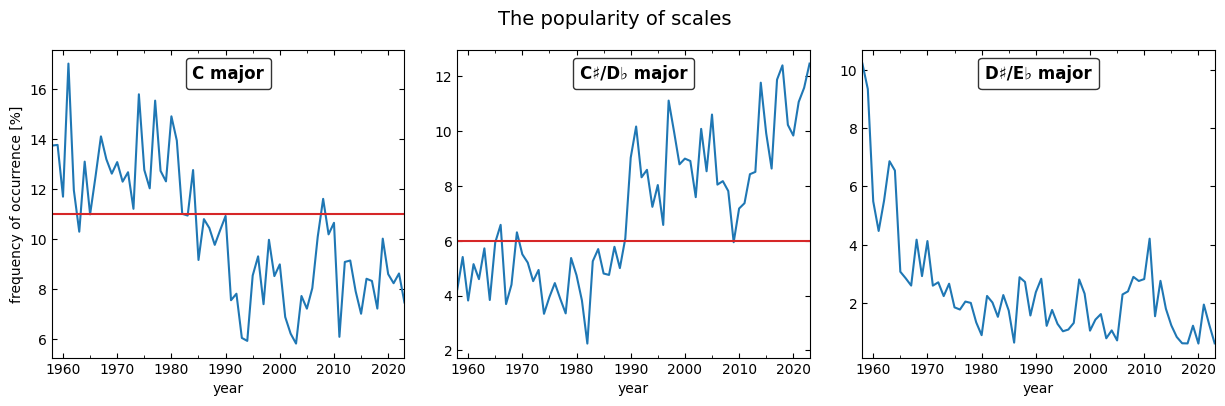

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# plot the scales frequencies
for scale_int, scale_str, ax in zip([1, 2, 4], 
    ['C major', 'C♯/D♭ major', 'D♯/E♭ major'], axes):
    scales_freq[scale_int].mul(100).plot(ax=ax)
    ax.legend([scale_str], prop={'weight': 'bold', 'size': 12}, 
        handlelength=0, handletextpad=0, loc='upper center')

fig.suptitle('The popularity of scales', fontsize=14)
fig.subplots_adjust(wspace=0.15)
axes[0].set_ylabel('frequency of occurrence [%]')

axes[0].axhline(y=11, color='tab:red')
axes[1].axhline(y=6, color='tab:red');

The *C major* scale (which is the most universal one overall) remained very popular in the '60s and the '70s, but then, around 1985, it's popularity decreased are remained below 11% threshold in further years (see the red horizontal line in the left panel). A reverse scenario can be observed for the *C♯/D♭ major* scale, which popularity (lower/higher) is separated by the 6% threshold, as shown in the middle plot. In both cases, the trends changed in a very similar time (around 1985/1990). On the other hand, the *D♯/E♭ major* case dropped rapidly after the '60s and remains at a low level of 1-2% nowadays.

Apart from the classical attributes discussed above, our data contain also special, Spotify-delivered features, which are based on the song tempo, mood, loudness etc. Investigating these properties, we can observe how the music audio aspects changed over time.

In the next cell we present the dynamics of the four following features:
* the **Energy** (the measure of the song intensity - in the upper left panel),
* the **Danceability** (the measure of the song suitability for dancing  - in the upper right panel),
* the **Valence** (the measure of the song musical positiveness - in the lower left panel), and
* the **Acousticness** (the measure of the song acousticness - in the lower right panel).

Each of the attributes listed above is given in the [0, 1] scale, with higher values denoting a bigger shift towards particular property (e.g., the valence closer to one (zero) indicates happier (sadder) track). We present the dynamics of the features using standard box plots, marking the outliers by the red dots.

**Note**: See the official [Spotify documentation](https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features) for more details on all of the available attributes.

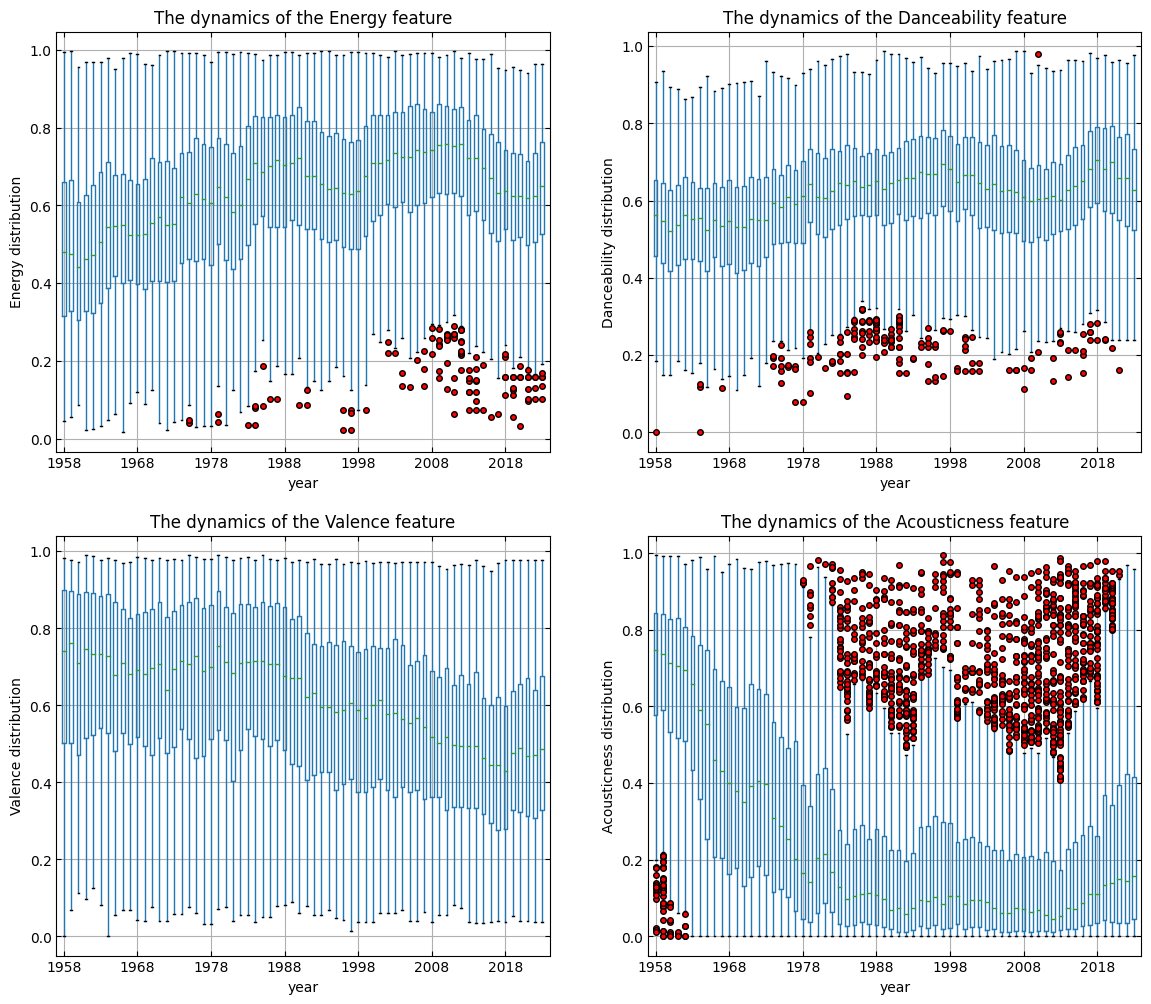

In [10]:
# the features of interest
feats = ['energy', 'danceability', 'valence', 'acousticness']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# plot the features
for feat, ax in zip(feats, axes.flatten()):
    spot_af.loc[:, feat].reset_index().groupby('year')\
        .boxplot(
            subplots=False, ax=ax, 
            flierprops={'marker': '.', 'markersize': 8, 'markerfacecolor': 'r'}
        )
    
    ax.set_xticks(ax.get_xticks()[::10])
    
    x_labels = [label.get_text()[1:5] for label in ax.get_xticklabels()]
    ax.set_xticklabels(x_labels)
    
    ax.set(xlim=(0, 67), xlabel='year', ylabel=f'{feat.title()} distribution', 
        title=f'The dynamics of the {feat.title()} feature')

As one can see in the upper left panel, the **energy** levels of the most successful songs increased from 1958, indicating that the modern music is more energetic than the one from the previous century. Beginning from 1988, the energy level fluctuates, remaining within the [0.6, 0.8] range (on average). A very similar scenario can be observed for the **danceability** property (in the upper right panel), but on a smaller scale.

On the other hand, the lower left subplot shows the **valence** of the tracks, which is continuously decreasing (the process has intensified in the 1990s). The results suggest that over the decades, more sadder songs found their way to the audience, since the smaller the valence, the more negative mood of the track (sad, depressed etc.). An even more extreme scenario can be observed for the **acousticness** feature (the lower right panel), which uncovers a rapid decline between the 1960s and the 1980s. In these circumstances, the tracks levels became much less acoustic, suggesting that the lyrics of the songs play a bigger role in modern music than sixty years ago.

To investigate more thoroughly how the dynamics of the features changed between decades, we can use both histograms and KDEs. At first, we will prepare a data frame (derived from the original `spot_af` one), where each year is transformed into appropriate decade - see the index in the table attached below.

In [11]:
# exclude incomplete decades
spot_af_dec = spot_af.loc[lambda x: (x.index >= '1960') & (x.index < '2020')]

# build the frame with the decades annotation
dec_temp = pd.DataFrame()
for decade, dec_df in spot_af_dec.resample('10Y'):
    dec_df.index = np.full(dec_df.index.size, str(decade.year) + 's')
    dec_temp = pd.concat([dec_temp, dec_df])

dec_temp.index.name = 'decade'
spot_af_dec = dec_temp

spot_af_dec.sample(3, random_state=0)

,artist_spot,song_spot,genres,key,key_mode,time_signature,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
decade,,,,,,,,,,,,,,,,
2000s,Glenn Lewis,Don't You Forget It,"['canadian pop', 'contemporary r&b', 'neo soul']",-7,0,4,0.720,0.513,-7.746,0.0720,0.1180,0.000000,0.1140,0.304,89.004,248773.0
1960s,The Shirelles,Mama Said,"['classic girl group', 'doo-wop', 'motown', 'r...",-2,0,4,0.701,0.322,-12.103,0.0685,0.5700,0.000000,0.1140,0.840,140.907,124502.0
1980s,Jennifer Holliday,Hard Times For Lovers,[],-11,0,4,0.524,0.863,-8.307,0.0450,0.0289,0.000076,0.0353,0.883,192.667,308200.0


Using the `spot_af_dec` frame, we can easily compare the decades for chosen music feature. In the next cell we show the KDEs of the **energy** attribute in two forms: (i) the classical estimations (left panel), and (ii) the violin plots (which combine KDEs with the box plots - see the right subplot below).

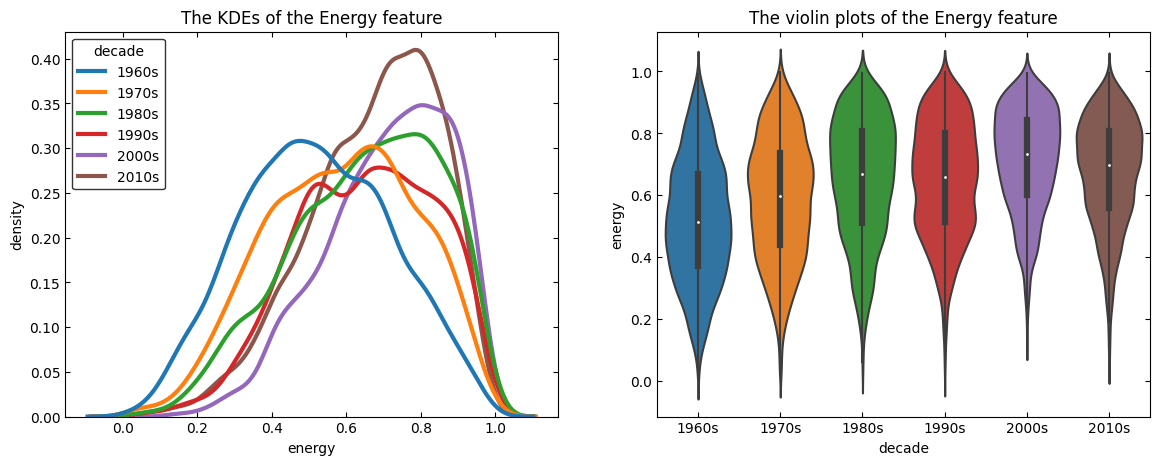

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.kdeplot(spot_af_dec, x='energy', hue='decade', ax=axes[0], linewidth=3)\
    .set(title='The KDEs of the Energy feature', ylabel='density')

sns.violinplot(spot_af_dec.reset_index(), x='decade', y='energy', 
    scale='width', ax=axes[1])\
    .set(title='The violin plots of the Energy feature');

The results summarized into decades confirm the observations discussed above. The levels of the music energy increased, and using the kernel estimations, one can indicate the ranges of the most dense results (where the majority of the songs reside; see, e.g., the brown peak corresponding to the 2010s).

An interesting phenomenon can be observed for the **loudness** feature, which distribution across the songs in the 1960s, 1990s and 2010s is shown in the following histograms:

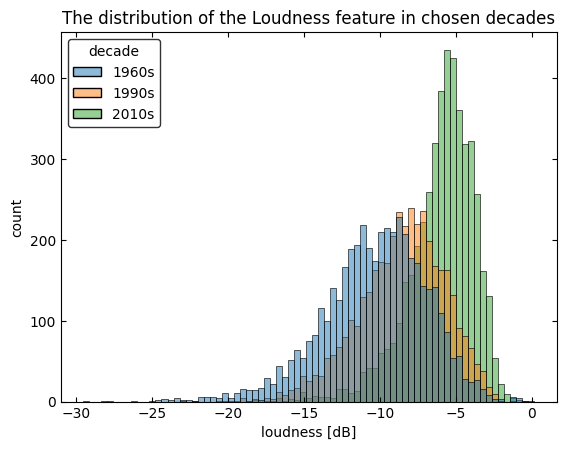

In [13]:
sns.histplot(spot_af_dec.loc[['1960s', '1990s', '2010s']], 
    x='loudness', hue='decade')

plt.gca().set(
    title='The distribution of the Loudness feature in chosen decades', 
    xlabel='loudness [dB]', ylabel='count'
);

The loudness (measured in [decibels [dB]](https://en.wikipedia.org/wiki/Decibel)) can be intuitively interpreted as the strength of the track signal - the higher the value, the louder (on average) the song.

**Note**: The values are negative, i.e., the ones closer to zero indicate louder tracks.

As one can see, in the 1960s (blue) the loudness was widely distributed across the songs, including both higher and lower levels. The situation started to change in the 1990s (orange), as the standards started to shift towards higher amplitudes. Nowadays (the 2010s curve shown in green), the average loudness is the highest one and the diversity in the levels is quite limited (see the bars accumulated around the -5 dB peak).

The phenomenon of loudness growth is known in the music industry as the *'loudness war'* and became especially noticeable with the introduction of digital songs processing. More details on the problem can be found [here](https://en.wikipedia.org/wiki/Loudness_war).

The Spotify database includes also the genres of the artists, which can be used to investigate the trends and the evolution of popularity of different types of music. At first, let's determine the total number of all the available genres, showing also some of their examples.

In [14]:
genres_series = pd.Series()

# collect the genres
for year, genre in spot_af.genres.items():
    # Note: The genres are represented in the original data frame 
    # as strings, not the `list` objects.
    genre = re.split(r"', '|', \"|\", '|\", \"", genre[2:-2])
    genres_series = pd.concat(
        [genres_series, pd.Series(genre, index=np.full(len(genre), year))]
    )

# remove empty genres
genres_series = genres_series[genres_series != '']

print('Available genres:', genres_series.nunique())
genres_series.sample(5, random_state=0)

Available genres: 1001


1995        classic rock
2008                rock
1989    contemporary r&b
1961      easy listening
1971         mellow gold
Freq: A-DEC, dtype: object

As we can see, our data contain 1001 different genres in total, but some of them are naturally related to each other (e.g., <font color=#ff7f0e>classic rock</font> and <font color=#ff7f0e>rock</font> styles listed above).

**Note**: A single artist can be associated with multiple genres.

The `genres_series` series includes all the genres of all the songs in the data (the tracks are indirectly related to the genres through their creators). We can use this series to indicate various statistics and possible trends in music, starting from evaluating the overall popularity of different styles using all the available years.

In [15]:
# top genres popularity (expressed in percentages)
genres_series.value_counts(normalize=True).mul(100).round(2).head(10)

soft rock               3.58
mellow gold             2.89
rock                    2.88
classic rock            2.77
pop                     2.74
rap                     2.38
album rock              2.37
country                 2.02
soul                    2.00
contemporary country    1.87
Name: proportion, dtype: float64

The highest score indicates that 3.58% of all the genres corresponds to <font color=#ff7f0e>soft rock</font>; the next three places are also correlated with the rock music (including <font color=#ff7f0e>mellow gold</font> style - see, e.g., [here](https://community.spotify.com/t5/Music-Discussion/All-Platforms-There-s-a-genre-called-mellow-gold/td-p/1738709)). Among the most popular genres we can also indicate <font color=#ff7f0e>pop</font> music, <font color=#ff7f0e>rap</font> or the <font color=#ff7f0e>country</font> one.

The list presented above in based on total aggregation and does not show the changes occurring between the decades (or years). To incorporate the latter ones, we evaluate the popularity of genres within each decade (from the 1960s to the 2010s), determining the rankings of Top 10 most popular styles (with percentages included). The results are shown in the next cell.

In [16]:
# aggregate the genres within each decade
genres_top = genres_series.loc[
    lambda x: (x.index >= '1960') & (x.index < '2020')
].groupby(pd.Grouper(freq='10Y')).value_counts(normalize=True)

genres_top.index.set_names(['decade', 'genre'], inplace=True)

# grab the Top 10 genres within each decade
genres_top = genres_top.to_frame('popularity').reset_index(-1).assign(
     ranking=lambda x: x.groupby(level=0).popularity\
         .transform('rank', ascending=False, method='first').astype(int), 
     genre=lambda x: x.genre + ' ('  + 
        x.popularity.mul(100).round(2).astype(str)  + '%)'
).query('ranking <= 10')

# show the results using pivot table
genres_top = genres_top.pivot_table(
    index='ranking', 
    columns='decade', 
    values='genre', 
    aggfunc=lambda x: x
)

genres_top.columns = np.vectorize(lambda x: x + 's')\
    (genres_top.columns.astype('str'))
genres_top.columns.name = 'decade'

genres_top

decade,1960s,1970s,1980s,1990s,2000s,2010s
ranking,,,,,,
1,rock-and-roll (6.7%),soft rock (7.46%),soft rock (8.48%),contemporary r&b (5.7%),dance pop (5.62%),pop (9.92%)
2,adult standards (4.91%),mellow gold (6.61%),album rock (6.17%),r&b (4.52%),country (5.11%),rap (8.05%)
3,soul (4.82%),classic rock (5.63%),mellow gold (5.83%),urban contemporary (3.97%),country road (5.02%),contemporary country (5.32%)
4,rockabilly (4.37%),soul (4.28%),classic rock (5.54%),rock (3.44%),contemporary country (4.58%),country road (4.97%)
5,classic soul (4.0%),album rock (4.19%),rock (5.13%),new jack swing (3.17%),pop (4.55%),hip hop (4.95%)
6,doo-wop (3.83%),rock (4.09%),new wave pop (4.99%),soft rock (2.51%),urban contemporary (4.47%),country (4.68%)
7,bubblegum pop (3.49%),singer-songwriter (3.83%),new romantic (3.75%),hip hop (2.36%),r&b (4.07%),trap (3.9%)
8,folk rock (3.35%),disco (3.7%),heartland rock (3.54%),new wave pop (2.36%),rap (3.16%),dance pop (3.76%)
9,easy listening (3.1%),folk rock (3.54%),hard rock (3.5%),dance pop (2.3%),hip hop (2.98%),pop rap (3.19%)


The '60s, '70s and '80s belonged to <font color=#ff7f0e>rock</font>, which different styles can be found in the highest positions in the rankings. The scenario started to change in the 1990s with the increase of popularity of modern <font color=#ff7f0e>r&b</font> music (see details on [contemporary R&B](https://en.wikipedia.org/wiki/Contemporary_R%26B)), and later due to <font color=#ff7f0e>pop</font> and <font color=#ff7f0e>rap</font> styles successes.

**Note**: For the clarity of presentation, the data frame presented above do not include ties (which in fact occurred for the 1960s at the 10th place: <font color=#ff7f0e>motown</font> and <font color=#ff7f0e>classic rock</font>, both with 2.91% popularity). Moreover, the (7th) <font color=#ff7f0e>hip hop</font> and the (8th) <font color=#ff7f0e>new wave pop</font> genres in the 1990s aggregation are also equal, with the same value of 2.36%.

Changing the aggregation granularity, we can compare the popularity of styles within particular year. The most recent results involving 2022 (the latest complete year) are shown in the cell below.

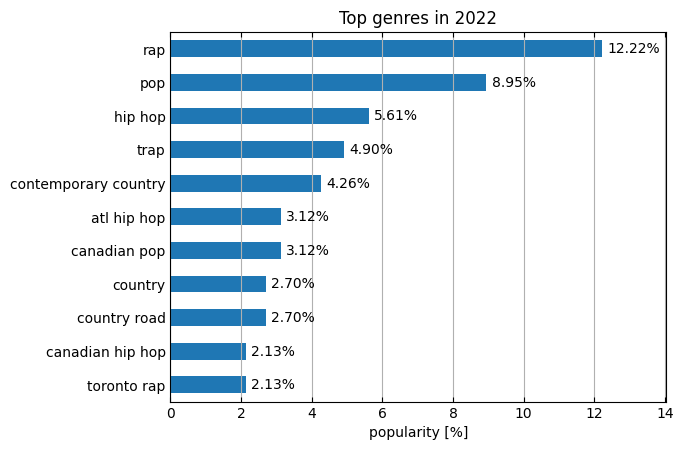

In [17]:
genres_year = '2022'

# grab the most popular genres in `genres_year`
genres_top_year = genres_series.loc[genres_year]\
    .value_counts(normalize=True).mul(100).nlargest(10, keep='all')

# and plot them using bars
ax = genres_top_year.plot(kind='barh')

ax.invert_yaxis()
ax.set(
    title=f'Top genres in {genres_year}', xlabel='popularity [%]', 
    xlim=(0, genres_top_year[0] * 1.15)
)
ax.grid(visible=True, axis='x')
ax.tick_params(left=False, right=False)

ax.bar_label(ax.containers[0], 
    labels=genres_top_year.apply('{:.2f}%'.format), padding=4);

The Top 11 genres (positions 10th and 11th are ties) involve in fact three main styles of music, i.e., <font color=#ff7f0e>rap</font>, <font color=#ff7f0e>pop</font> and <font color=#ff7f0e>country</font>, expressed using various derivatives. The most popular genre last year was <font color=#ff7f0e>rap</font> (12.22% of tracks), which different variations can be also found in the list (e.g., the <font color=#ff7f0e>trap</font> style; read also [here](https://www.nextlevel-usa.org/blog/rap-vs-hip-hop) on the difference between *rap* and *hip hop*, since the latter label occurs in the data either). The <font color=#ff7f0e>pop</font> music accounted for 8.95% of the tracks, while <font color=#ff7f0e>contemporary country</font> - for 4.26%.

**Note**: In many cases, the artist is associated with numerous genres which originate from the main one (e.g., ['hip hop', 'rap', 'southern hip hop', 'trap']).

The current level of details in the data makes it harder to compare the genres in a comprehensive way. For further analysis, we combine the labels into more general groups, indicating the original genre from which the branches originate.

Namely, let's focus on the following music styles:
* <font color=#ff7f0e>pop</font>,
* <font color=#ff7f0e>rock</font>,
* <font color=#ff7f0e>rap</font>,
* <font color=#ff7f0e>trap</font>, and
* <font color=#ff7f0e>country</font>.

The `genres_popul` function (see the <a href='utils.py'>`utils.py`</a> file for details) allows to estimate the popularity of any set of genres and express it using one of the two possible levels of granularity - yearly or by decades (the `decades` parameter). The original data are examined for any labels containing the genre phrase (e.g., when using the <font color=#ff7f0e>pop</font> label, <font color=#ff7f0e>k-pop</font> or <font color=#ff7f0e>dance pop</font> styles are considered are derivatives and also counted in), which allows to improve the estimation.

In the next cell we use the tool to find the popularity of the genres listed above on the yearly basis.

**Note**: For the <font color=#ff7f0e>rap</font> genre we use the multiple `[rap, hip hop]` label, since some of the artists are annotated with either <font color=#ff7f0e>rap</font>, or <font color=#ff7f0e>hip hop</font>. It should be noted that the <font color=#ff7f0e>rap</font> category includes the <font color=#ff7f0e>trap</font> one, but we also examine the latter genre alongside for comparison.

In [18]:
from utils import genres_popul

genres_list = ['pop', 'rock', ['rap', 'hip hop'], 'trap', 'country']

genres_yearly = genres_popul(genres_list, genres_src=spot_af.genres)
genres_yearly

,pop,rock,rap,trap,country
year,,,,,
1958,0.157205,0.449782,0.000000,0.000000,0.069869
1959,0.199422,0.430636,0.002890,0.000000,0.052023
1960,0.220708,0.444142,0.000000,0.000000,0.040872
1961,0.204852,0.433962,0.000000,0.000000,0.035040
1962,0.262873,0.390244,0.000000,0.000000,0.046070
...,...,...,...,...,...
2019,0.465021,0.080247,0.493827,0.195473,0.146091
2020,0.407867,0.057971,0.521739,0.167702,0.144928
2021,0.424779,0.075221,0.469027,0.130531,0.159292


Using the data frame containing yearly genres popularity, we can easily observe how the styles evolved in time.

**Note**: The nonzero value at <font color=#ff7f0e>(1959, rap)</font> corresponds to <font color=#ff7f0e>jazz vibraphone</font> genre, which name unfortunately contains the *'rap'* substring. The problem with substrings occurred for this one particular record only.

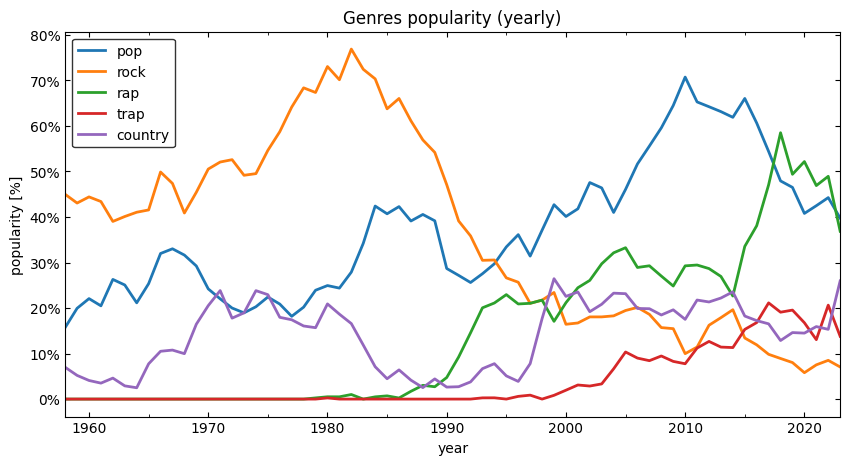

In [19]:
from matplotlib.ticker import PercentFormatter

genres_yearly.at['1959', 'rap'] = 0  # improve the 'jazz vibraphone' record

genres_yearly.plot(
    title='Genres popularity (yearly)', 
    xlabel='year', ylabel='popularity [%]', figsize=(10, 5), lw=2
)

plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

The winning position of <font color=#ff7f0e>rock</font> music in the overall popularity ranking can be easily explained by its enormous successes before 1990 (the orange plot). In the peak of its development (around 1980), almost four out of five of the most popular songs of that time involved some rock 'n' roll. After 1985, its popularity started to decline, being replaced mainly by <font color=#ff7f0e>pop</font> and arising <font color=#ff7f0e>rap</font> (the blue and the green curves, respectively). The most recent results (2020 onwards) show, that the latter two styles are highly competing and remain quite close to each other.

An interesting scenario can be observed for <font color=#ff7f0e>country</font> music (the violet plot), which gained in popularity around 1970 (the result close to 20%) and then declined in 1985 (below 10%). Beginning from 2000 we can observe another comeback of this style, which in the last 20 years oscillated around 20%. Also <font color=#ff7f0e>trap</font> is doing quite well (marked by the red curve), becoming one of the most popular derivatives of hip hop music in recent years.

To compare the genres popularity in more readable way, we can produce simple pie charts based on the selected level of data aggregation. In the next cell we visualize <font color=#ff7f0e>pop</font>, <font color=#ff7f0e>rock</font> and <font color=#ff7f0e>rap</font> styles, depending on their successes within chosen decades.

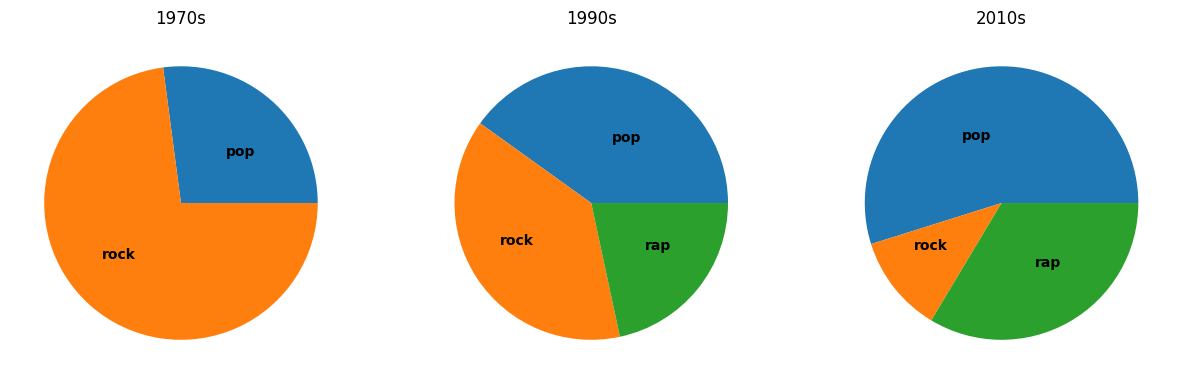

In [20]:
# grab the genres popularity
genres_decade = genres_popul(genres_list, genres_src=spot_af.genres, 
    decades=True).iloc[:, :3]
genres_decade.at['1970s', 'rap'] = 0.0  
# Note: We exclude `The Sugarhill Gang - Rapper's Delight` (1979) for clarity 
# (the only one rap track from the 1970s in our data).

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

decades = ['1970s', '1990s', '2010s']

# plot the pies
for decade, ax in zip(decades, axes):
    gen_dec = genres_decade.loc[decade]
    pie_data = gen_dec / gen_dec.sum()
    labels = [label if (prop > 0) else '' for label, prop in pie_data.items()]
    ax.pie(pie_data, labels=labels, labeldistance=0.5, 
        textprops=dict(weight='bold'))
    ax.set_title(decade)

The slices of the pies indicate the ratios between the genres. In the 1970s, <font color=#ff7f0e>rock</font> music was almost three times more popular than the <font color=#ff7f0e>pop</font> one (we have excluded the unique rap song from this decade, i.e., the *1979: The Sugarhill Gang - Rapper's Delight* track for pie clarity). Then, in the 1990s the genres popularity became almost equal and <font color=#ff7f0e>rap</font> started to grow (with around half the popularity of <font color=#ff7f0e>pop</font> or <font color=#ff7f0e>rock</font>). In the most recent decade (2010s), <font color=#ff7f0e>pop</font> was the most successful genre, overtaking <font color=#ff7f0e>rap</font> by almost 2/3 and <font color=#ff7f0e>rock</font> nearly 4 times (all the ratios can be calculated using the `genres_decade` frame).

As we have mentioned above, the genres in our data are assigned to artists, depending on their Spotify classification. In many cases the creator is associated with multiple labels (which can originate from the main style, e.g., rap and its derivatives) but it can also combine some not straightforward types. Choosing particular genre-label, we can investigate all its available connections, including the number of artists representing them.\
In the next cell we build the frame containing all the creators and their musical styles.

In [21]:
artists_genres = spot_af[['artist_spot', 'genres']].query('genres != "[]"')\
    .drop_duplicates().reset_index(drop=True)

artists_genres.sample(5, random_state=0)

,artist_spot,genres
1784,Duran Duran,"['album rock', 'classic rock', 'dance rock', '..."
2805,Meredith Brooks,"['lilith', 'new wave pop', 'pop rock']"
3443,Fort Minor,['rap rock']
3490,Dashboard Confessional,"['emo', 'neon pop punk', 'pop punk', 'pop rock']"
1696,Jesse Winchester,['folk']


The lists shown in the **genres** column indicate all the styles associated with particular artist. Let's focus on the <font color=#ff7f0e>rap</font> label, finding all its collaborations among the available genres.

In [22]:
genre_main = 'rap'
genres_all = artists_genres.genres.values

genres_related = np.array([])

# find all `genre_main` collaborations
for genre in genres_all:
    genres_list = re.split(r"', '|', \"|\", '|\", \"", genre[2:-2])
    if genre_main in genres_list:
        if len(genres_list) == 1:
            genres_related = np.append(genres_related, '#standalone')
        else:        
            genres_list.remove(genre_main)
            genres_related = np.append(genres_related, genres_list)

related_counts = np.unique(genres_related, return_counts=True)

# create a data frame containing collaborations counts
related_counts_df = pd.DataFrame(
    index=related_counts[0], 
    data={'counts': related_counts[1]}
).sort_values('counts', ascending=False)

related_counts_df.head(10)

,counts
trap,74
hip hop,68
pop rap,48
southern hip hop,41
gangster rap,28
atl hip hop,25
melodic rap,20
r&b,18
east coast hip hop,14
dirty south rap,11


The table presented above (limited to ten highest results) contains the genres related to <font color=#ff7f0e>rap</font>, along with the number of artists representing given collaboration (the **counts** column). For example, 74 creators have been associated by Spotify with both <font color=#ff7f0e>rap</font> and <font color=#ff7f0e>trap</font> styles (among other possible labels). Many of the genres are naturally related (<font color=#ff7f0e>rap</font>, <font color=#ff7f0e>trap</font>, <font color=#ff7f0e>hip hop</font> etc.), but we can also indicate some interesting, modern combinations, like the <font color=#ff7f0e>pop rap</font> one, which fuses the elements of both styles (see [here](https://en.wikipedia.org/wiki/Pop_rap) for more details).

Finding the artists representing multiple genres can be done easily (see the example for <font color=#ff7f0e>rap</font> and <font color=#ff7f0e>pop rap</font> given below).

**Note**: Although the Spotify genres are quite accurate, it should be noted that the classification is still subjective, including the styles introduced directly by the Service (e.g., the <font color=#ff7f0e>mellow gold</font> one mentioned earlier).

In [23]:
with pd.option_context('display.max_colwidth', None):
    display(artists_genres.query('genres.str.contains("\'rap\'") '
        'and genres.str.contains("\'pop rap\'")'))

,artist_spot,genres
2505,Snoop Dogg,"['g funk', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'west coast rap']"
2539,Fat Joe,"['bronx hip hop', 'dirty south rap', 'east coast hip hop', 'gangster rap', 'hardcore hip hop', 'hip hop', 'pop rap', 'rap', 'trap']"
2745,Busta Rhymes,"['east coast hip hop', 'hardcore hip hop', 'hip hop', 'pop rap', 'rap']"
2761,JAY-Z,"['east coast hip hop', 'gangster rap', 'hip hop', 'pop rap', 'rap']"
2767,Lil' Kim,"['dance pop', 'east coast hip hop', 'gangster rap', 'hip hop', 'hip pop', 'pop rap', 'r&b', 'rap', 'southern hip hop', 'trap queen', 'urban contemporary']"
2826,Missy Elliott,"['dance pop', 'hip hop', 'hip pop', 'neo soul', 'pop rap', 'r&b', 'rap', 'urban contemporary', 'virginia hip hop']"
2987,Ja Rule,"['dance pop', 'east coast hip hop', 'gangster rap', 'hip hop', 'hip pop', 'pop rap', 'queens hip hop', 'rap', 'urban contemporary']"
3026,Lil Wayne,"['hip hop', 'new orleans rap', 'pop rap', 'rap', 'trap']"
3036,Nelly,"['dance pop', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'st louis rap', 'urban contemporary']"
3055,Ludacris,"['atl hip hop', 'dance pop', 'dirty south rap', 'hip hop', 'old school atlanta hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']"


Investigating our data we can also study the distribution of the features typical for chosen music style. The results can be further used to compare the genres and indicate both similarities and differences between them.

In the following example we focus on the **danceability** feature, which determines the suitability of the song for dancing (the value is based on the track tempo, rhythm stability etc.). Aggregating the data by decades, we compare how the feature changed between <font color=#ff7f0e>pop</font> and <font color=#ff7f0e>rock</font> (the upper panels) and <font color=#ff7f0e>pop</font> and <font color=#ff7f0e>rap</font> (the lower ones). The box and the count plots are shown in the left and the right subfigures, respectively.

**Note**: While collecting the data for the genres, we do not consider the tracks (artists) representing both styles or any combination of relative ones (e.g., the <font color=#ff7f0e>pop rap</font>). The exclusion of possible mixes prevents the interference of the genres feature representation, allowing to compare the music styles in more clear way. It should be noted that the applied methodology results in different data within each genres pair - see the differences for the <font color=#ff7f0e>pop</font> results between the upper and the lower panels below.

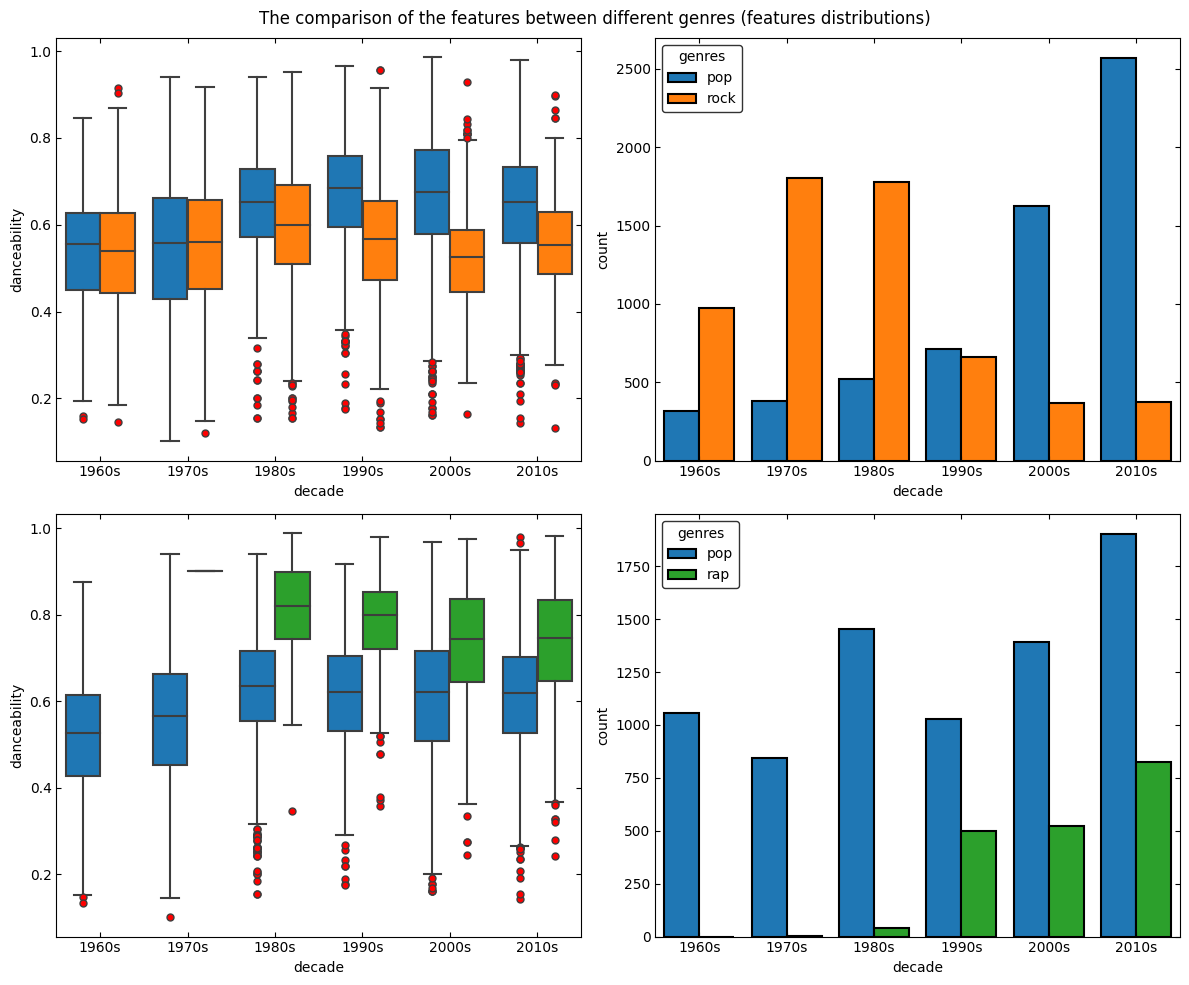

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
genre_main = 'pop'
feature_main = 'danceability'

# get the pairs data
for ax_comp, genre_comp, col in zip(axes, ['rock', 'rap|hip hop'], 
    ['tab:orange', 'tab:green']):
    df_main = spot_af_dec.query(f'genres.str.contains("{genre_main}") '
        f'and not genres.str.contains("{genre_comp}")')\
        .assign(genres=genre_main)
    df_comp = spot_af_dec.query(f'genres.str.contains("{genre_comp}") '
        f'and not genres.str.contains("{genre_main}")')\
        .assign(genres=re.split('\|', genre_comp)[0])
    df_combined = pd.concat([df_main, df_comp]).reset_index()
    
    # plot boxes
    sns.boxplot(
        data=df_combined, ax=ax_comp[0], 
        x='decade', y=feature_main, hue='genres', 
        palette=['tab:blue', col], saturation=1.0, 
        flierprops=dict(marker='o', markerfacecolor='r')
    )
    ax_comp[0].get_legend().remove()
    
    # plot counts
    sns.countplot(
        data=df_combined, ax=ax_comp[1], 
        x='decade', hue='genres', 
        palette=['tab:blue', col], saturation=1.0, 
        edgecolor='k', linewidth=1.5
    )

fig.suptitle('The comparison of the features between different genres '
    '(features distributions)')
plt.tight_layout()

As one can see in the upper left subplot, the danceability for <font color=#ff7f0e>pop</font> (blue) and <font color=#ff7f0e>rock</font> (orange) songs was very similar in the '60s and the '70s. Then, within the next decades the styles started to separate, as the danceability of <font color=#ff7f0e>rock</font> music decreased. In the most recent 2010s we can see that the values got closer again.

An inverse scenario occurs between <font color=#ff7f0e>pop</font> (blue) and <font color=#ff7f0e>rap</font> (green) tracks, presented in the lower left subplot. In this case, <font color=#ff7f0e>rap</font> danceability converged to the <font color=#ff7f0e>pop</font> one, as shown by the green boxes that lower over time. Interestingly, beginning from the 1980s, <font color=#ff7f0e>pop</font> danceability remains on average on the same stable level.

**Note**: The boxes discussed above are based on different sample sizes for each genre (see the count plots in the right figure panels), which can influence the feature distribution estimation (especially for the samples of small size).

The comparison of the features between different genres can be also expressed using scatter plots, as shown in the next cell regardless the decade. Using the planes, we combine **danceability** and **speechiness** for <font color=#ff7f0e>pop</font> and <font color=#ff7f0e>rock</font> (the left subfigure), and **acousticness** and **speechiness** for <font color=#ff7f0e>pop</font> and <font color=#ff7f0e>rap</font> (the right subfigure).

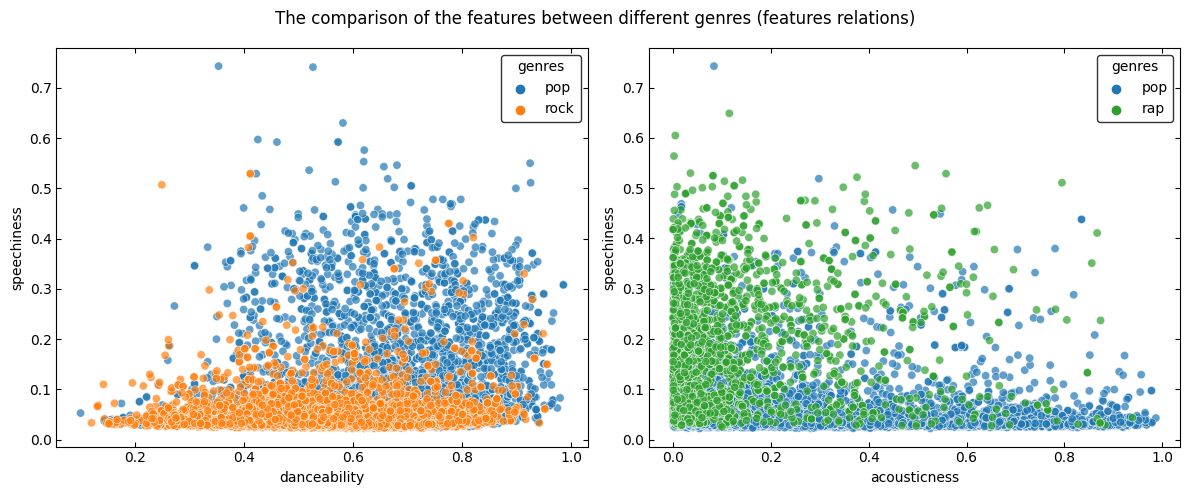

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
genre_main = 'pop'

# get the pairs data
for ax, genre_comp, col, feat in zip(axes, ['rock', 'rap|hip hop'], 
    ['tab:orange', 'tab:green'], ['danceability', 'acousticness']):
    df_main = spot_af_dec.query(f'genres.str.contains("{genre_main}") '
        f'and not genres.str.contains("{genre_comp}")')\
        .assign(genres=genre_main)
    df_comp = spot_af_dec.query(f'genres.str.contains("{genre_comp}") '
        f'and not genres.str.contains("{genre_main}")')\
        .assign(genres=re.split('\|', genre_comp)[0])
    df_combined = pd.concat([df_main, df_comp]).reset_index()
    
    # plot points
    sns.scatterplot(
        data=df_combined, ax=ax, 
        x=feat, y='speechiness', hue='genres', 
        palette=['tab:blue', col], alpha=0.7
    )

fig.suptitle('The comparison of the features between different genres '
    '(features relations)')
plt.tight_layout()

The results show that the speechiness of <font color=#ff7f0e>rock</font> music (the orange dots) is much smaller when compared to the <font color=#ff7f0e>pop</font> one (the blue dots); the higher the value, the more exclusively speech-like the recording is. It can be also observed that the tracks with the lowest danceability within the genres are also the ones with quite small speechiness. On the other hand, the acousticness levels of the <font color=#ff7f0e>rap</font> songs are mainly limited to the values below 0.2-0.4, while being widely distributed for the <font color=#ff7f0e>pop</font> tracks (see the green and the blue dots in the right panel). The acousticness measures the confidence of the track being acoustic, and its high values are naturally correlated with a low speechiness, as can be observed in the figure.

Finalizing our investigations, let's examine the relations between the features using all of the data (i.e., regardless the genres and the years). The scatter plots shown below compare: (left) the **speechiness** and the **instrumentalness** (the larger the instrumentalness value, the smaller the vocal content of the track), and (right) the **loudness** and the **energy** (the measure of the song intensity and activity).

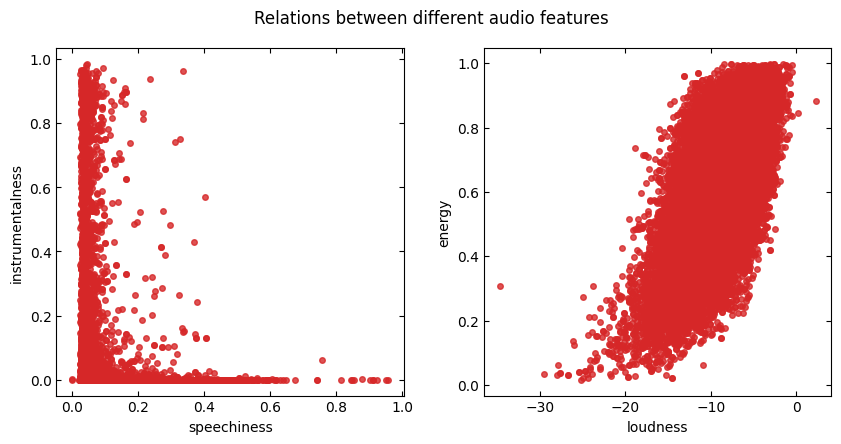

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# create scatter plots for the features pairs
for ax, feat1, feat2 in zip(axes, ['speechiness', 'loudness'], 
    ['instrumentalness', 'energy']):
    ax.plot(
        spot_af[feat1], spot_af[feat2], 
        marker='o', linestyle='', color='tab:red', 
        markersize=4, alpha=0.8
    )
    ax.set(xlabel=feat1, ylabel=feat2, box_aspect=1)

fig.suptitle('Relations between different audio features', y=0.92)
fig.subplots_adjust(wspace=0.23)

The results represent quite natural relations which can be explained using features meanings. Considering the first pair (in the left subplot), one can see that the tracks with the highest **speechiness** are also the least **instrumentalness** ones, since the former feature indicates the vocal-mainly compositions (we have seen a very similar interaction between the **speechiness** and the **acousticness** discussed above). A more complex relation can be observed for the **loudness** and the **energy** attributes (see the right panel), which in general constitute a positive correlation, i.e., the higher the loudness, the higher the energy (although the width of the 'correlation curve' is quite robust in this case). The result is understandable, since the Spotify energy value is partially based on the song perceived loudness (among other features involved).

We can also see how the features vary between different technical properties of the tracks. For the comparison, let's focus on the songs **key_mode**, which is originally expressed in the data by integer values (zero for the *minor* mode and one for the *major* mode).

For clarity, we first transform the integer notation into strings and limit the columns to *mode* and *main features* only. We also exclude the records released before 2000 to make the data more consistent (modern music only). Then for each feature we plot its distribution (using box plots), split between the songs composed in the *major* (light violet) and the *minor* (dark violet) scales. The results are shown as follows:

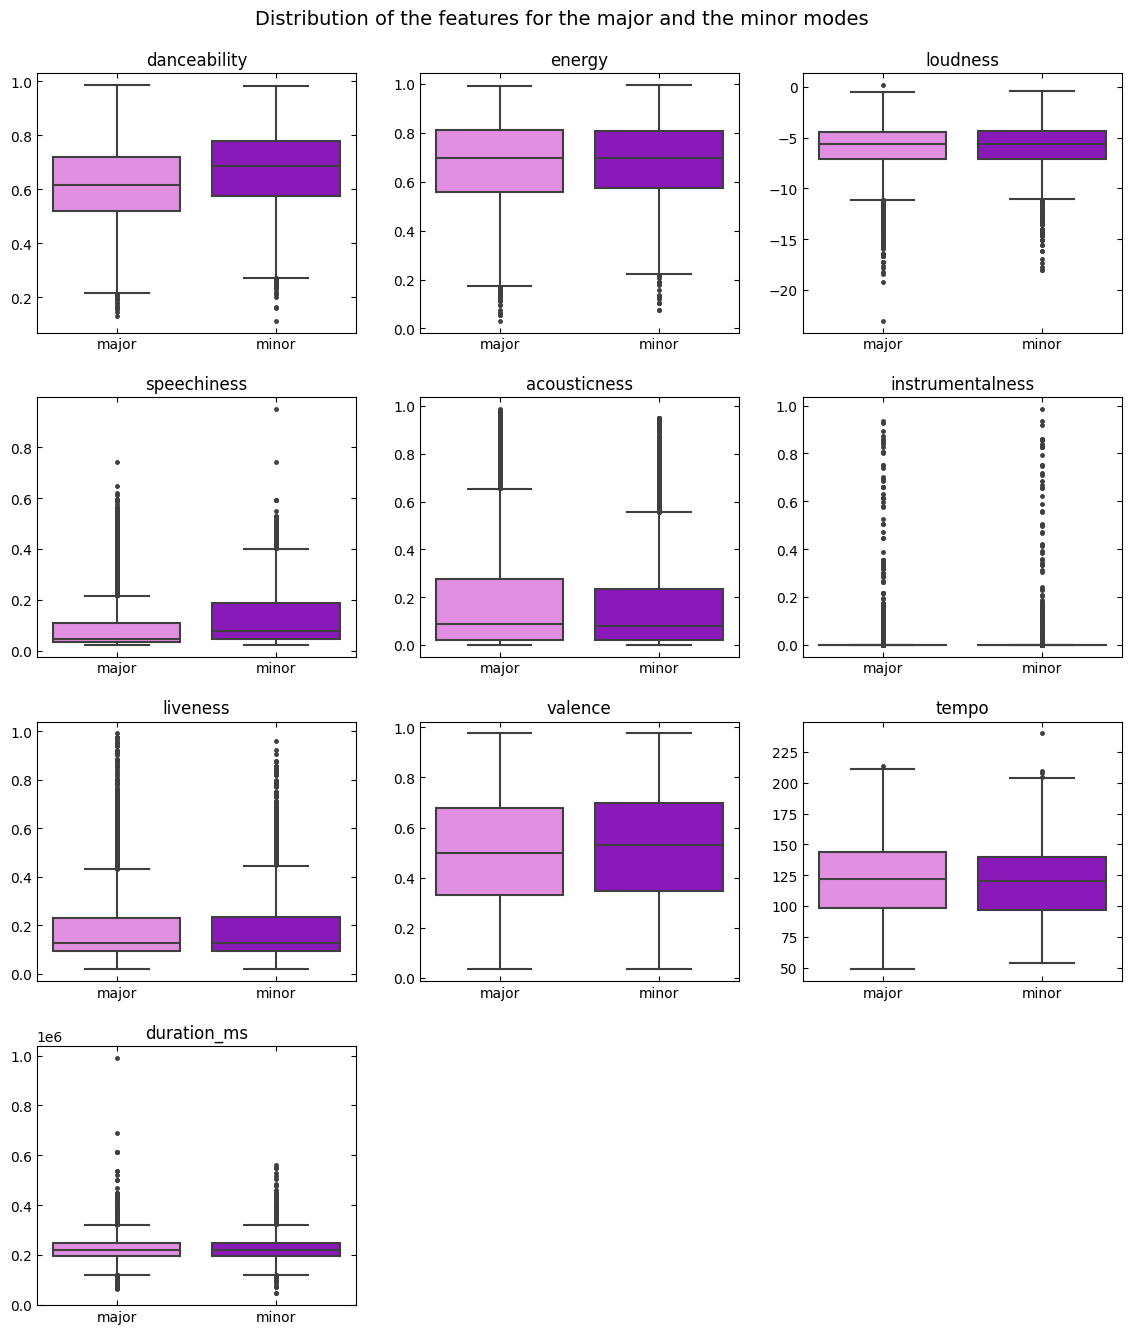

In [27]:
# transform the data
spot_af_mode = spot_af[spot_af.index >= '2000']\
    .iloc[:, np.r_[4, 6:spot_af.shape[1]]].assign(
    key_mode=lambda x: x.key_mode.replace([0, 1], ['minor', 'major'])
)

feat_n = (spot_af_mode.shape[1] - 1)
ax_rows = feat_n // 3 + 1

fig, axes = plt.subplots(ax_rows, 3, figsize=(14, 4 * ax_rows))

# plot the distributions
for ax, feat in zip(axes.flatten(), spot_af_mode.columns[1:]):
    sns.boxplot(
        spot_af_mode, ax=ax, 
        x='key_mode', y=feat, 
        palette=['violet', 'darkviolet'], flierprops={'marker': '.'}
    )
    ax.set(xlabel='', ylabel='', title=feat)

fig.suptitle('Distribution of the features for the major and the minor modes', 
    y=0.92, fontsize=14)
fig.subplots_adjust(hspace=0.25)

for ax in axes.flatten()[feat_n:]:
    ax.remove()

For the majority of the features, we cannot indicate any significant differences between the modes. A possible diverse can be noticed for the **danceability** (the *minor* compositions occupy slightly higher values than the *major* ones) and the **speechiness** - in this category the *minor* tracks are also exceeding the *major* ones.

Using the data we can perform a similar analysis for the musical scales (the **key** column), but in this case the number of possible categories is much higher than for the modes (12 keys in total, or 24 including the modes).

The research presented above involved only a small portion of possible applications of the Spotify features database. Investigating the Service API capabilities, one can query the data of various musical types (songs, artists, albums etc.), performing more complex analyses and using them in practical applications.